# Import all the libraries

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


# Loading the Airbnb dataset below:

- Check confusion matrix 
- see the distribution/spread for the NDCG score for the model


You can download the user_training_dataset_update.csv from the link below:

https://drive.google.com/open?id=1tQGlNvkmGVPGcmQID2NNd5p8bkLBxofM

In [218]:
user_training_dataset_update=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/user_training_dataset_update.csv")

user_training_dataset_update_multinary_classfication=user_training_dataset_update.copy()
user_training_dataset_update_multinary_classfication.loc[user_training_dataset_update_multinary_classfication['first_browser']=='-unknown-', 'first_browser']='Unknown'
user_training_dataset_update_multinary_classfication.loc[user_training_dataset_update_multinary_classfication['gender']=='-unknown-', 'gender']='Unknown'



In [220]:
del user_training_dataset_update_multinary_classfication['trip_booking_flag']                                          

In the user_training_dataset_update_multinary_classfication dataset, the following fields have some missing values:
- first_affiliate_tracked 
- age_computed
- Total time spent (in seconds) 
- Account_creation_before_booking_flag 
- session count  

In [221]:
user_training_dataset_update_multinary_classfication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 33 columns):
id                                                         213451 non-null object
date_account_created                                       213451 non-null object
timestamp_first_active_cleaned                             213451 non-null object
gender                                                     213451 non-null object
signup_method                                              213451 non-null object
signup_flow                                                213451 non-null int64
language                                                   213451 non-null object
affiliate_channel                                          213451 non-null object
affiliate_provider                                         213451 non-null object
first_affiliate_tracked                                    207386 non-null object
signup_app                                                 213451 non-

Input the null value for first_affiliate_tracked field as "unknown"

In [205]:
user_training_dataset_update_multinary_classfication['first_affiliate_tracked'].unique()

array(['untracked', 'omg', nan, 'linked', 'tracked-other', 'product',
       'marketing', 'local ops'], dtype=object)

In [222]:
user_training_dataset_update_multinary_classfication.loc[pd.isnull(user_training_dataset_update_multinary_classfication['first_affiliate_tracked']), 'first_affiliate_tracked']='Unknown'

user_training_dataset_update_multinary_classfication['first_affiliate_tracked'].value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
Unknown            6065
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

Input the null value for "Account_creation_before_booking_flag" as "unknown"

In [223]:
user_training_dataset_update_multinary_classfication.loc[pd.isnull(user_training_dataset_update_multinary_classfication['Account_creation_before_booking_flag']), 'Account_creation_before_booking_flag']='Unknown'

user_training_dataset_update_multinary_classfication['Account_creation_before_booking_flag'].value_counts()

Unknown    124543
2.0         67475
1.0         21404
0.0            29
Name: Account_creation_before_booking_flag, dtype: int64

Define the NDCG score function:

Define function to convert all the categorical variables into dummy variables:

In [224]:
def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df

In [225]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication.copy()

Include all the relevant fields into the dataset used for the multi class model:  user_training_dataset_update_multinary_classfication1

In [226]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1[[
'id',
    
# Below are the category variables:
'gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket',                                          

#Below are the continuous variables:

'number_of_active_day_as_of_latest_date', 
'number_of_days_since_account_creation_as_of_latest_date',
'Total time spent (in seconds)_fill_null_zero',   
'session count_fill_null_zero', 
    
#Below's the label variable:
'country_destination' ]]                                                                                                 

In [227]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.set_index('id')

All the data in the user_training_dataset_update_multinary_classfication1 dataset does not have missing values:

In [228]:
user_training_dataset_update_multinary_classfication1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213451 entries, gxn3p5htnn to nw9fwlyb5f
Data columns (total 27 columns):
gender                                                     213451 non-null object
signup_method                                              213451 non-null object
signup_flow                                                213451 non-null int64
language                                                   213451 non-null object
affiliate_channel                                          213451 non-null object
affiliate_provider                                         213451 non-null object
first_affiliate_tracked                                    213451 non-null object
signup_app                                                 213451 non-null object
first_device_type                                          213451 non-null object
first_browser                                              213451 non-null object
Account_creation_before_booking_flag                       213

Encode the category variables into dummy variables:

List out all the categorical variables name into the Categorical_variable_list:

In [229]:
Categorical_variable_list=['gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket']

In [230]:
def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df

In [231]:
for variable_name in Categorical_variable_list:
    df_dummy=func_get_dummy_variables_for_categorical_variables(user_training_dataset_update_multinary_classfication1, variable_name)
    user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.merge(df_dummy, on=None, left_index=True, right_index=True)

In [232]:
user_training_dataset_update_multinary_classfication1.columns

Index(['number_of_active_day_as_of_latest_date',
       'number_of_days_since_account_creation_as_of_latest_date',
       'Total time spent (in seconds)_fill_null_zero',
       'session count_fill_null_zero', 'country_destination', 'gender_FEMALE',
       'gender_MALE', 'gender_OTHER', 'gender_Unknown', 'signup_method_basic',
       ...
       'session count_bucket_(111.0, 2644.0]',
       'session count_bucket_(26.0, 53.0]',
       'session count_bucket_(53.0, 111.0]', 'session count_bucket_Unknown',
       'Total time spent (in seconds)_bucket_(-0.001, 169857.6]',
       'Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]',
       'Total time spent (in seconds)_bucket_(169857.6, 584557.4]',
       'Total time spent (in seconds)_bucket_(2444996.4, 38221363.0]',
       'Total time spent (in seconds)_bucket_(584557.4, 1248857.2]',
       'Total time spent (in seconds)_bucket_Unknown'],
      dtype='object', length=286)

Check if there's any null value in the user_training_dataset_update_binary_classfication1 dataset:

In [233]:
for column in user_training_dataset_update_multinary_classfication1.columns:
    row_count=user_training_dataset_update_multinary_classfication1[column].count()
    if row_count<213451:
        print(column)

There's no column with null value after having preprocessed the data.

Define the feature list:

In [234]:
feature_list1=list(user_training_dataset_update_multinary_classfication1.columns)

In [235]:
feature_list1.remove('Total time spent (in seconds)_fill_null_zero')
feature_list1.remove('session count_fill_null_zero')

In [236]:
feature_list2=list(user_training_dataset_update_multinary_classfication1.columns)

In [237]:
feature_list2.remove('Total time spent (in seconds)_bucket_(-0.001, 169857.6]')
feature_list2.remove('Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]')
feature_list2.remove('Total time spent (in seconds)_bucket_(169857.6, 584557.4]')
feature_list2.remove('Total time spent (in seconds)_bucket_(2444996.4, 38221363.0]')
feature_list2.remove('Total time spent (in seconds)_bucket_(584557.4, 1248857.2]')
feature_list2.remove('Total time spent (in seconds)_bucket_Unknown')

feature_list2.remove('session count_bucket_(0.999, 10.0]')
feature_list2.remove('session count_bucket_(10.0, 26.0]')
feature_list2.remove('session count_bucket_(111.0, 2644.0]')
feature_list2.remove('session count_bucket_(26.0, 53.0]')
feature_list2.remove('session count_bucket_(53.0, 111.0]')
feature_list2.remove('session count_bucket_Unknown')

Remove the trip_booking_flag variable  (label):

In [238]:
feature_list2.remove('country_destination')       
feature_list1.remove('country_destination')   

#  Develop multi class classification model. Use Country Destination as the label and rest of the variables as features


# Use Logistic Regression to fit the model: 

Define the label and feature:

In [25]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list1]

Create the training and testing vars:

Split the training dataset and testing set into two parts: 
- Training dataset (80%)
- Testing dataset(20%

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [219]:
print("Shape of traing feature set:", X_train.shape)
print("Shape of testing feature set:", X_test.shape)
print("Shape of training label set:", y_train.shape)
print("Shape of testing label set:", y_test.shape)

Shape of traing feature set: (170760, 273)
Shape of testing feature set: (42691, 273)
Shape of training label set: (170760,)
Shape of testing label set: (42691,)


In [49]:
Multinary_Logistic_Regression=LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [50]:
Multinary_Logistic_Regression.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Model Performance on the testing set:

In [191]:
print("Accuracy Score: ", cross_val_score(Multinary_Logistic_Regression, X_train,y_train, cv=5).mean())

Accuracy Score:  0.752763399127302


# Below is detail NDCG (Normalized discounted cumulative gain) evaluation provided by Kaggle competition:

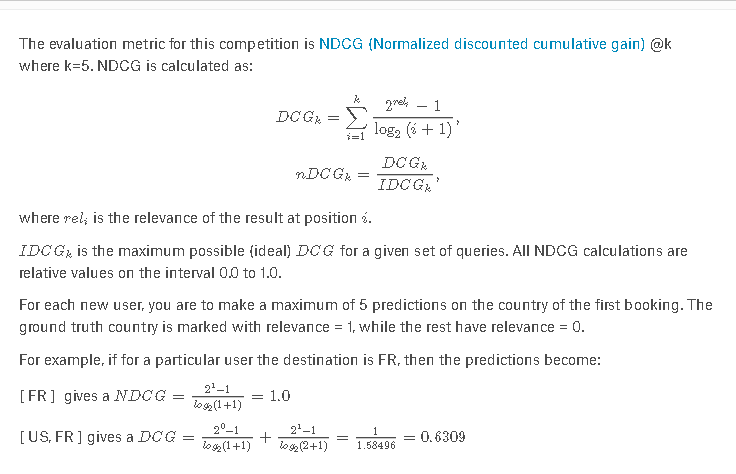

# Define a function to get the predict probability by user:

Define a function to output model prediction probability by class:

In [52]:
multinary_classification_model=Multinary_Logistic_Regression
training_data_features=X_train

In [53]:
multinary_classification_model.classes_

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

# Define a function which takes in classification model and the training features and output the top five destination countries by user id based on the probability of the classes:

In [452]:
def multinary_classification_model_predict_probability_by_class(multinary_classification_model, training_data_features):
    
    ordered_label=multinary_classification_model.classes_
    #Create a dictionary of label classes:
    
    i=0
    label_order_dict=dict()
    
    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1
    
    #Create a dataframe for classification probability
    
    df_prob=pd.DataFrame()
    #Create a dataframe to include thte probability of each class by user id
    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*multinary_classification_model.predict_proba(training_data_features)))[probability_order]
    
    #Use the training data features index (user id) as the index for the classification probability data frame
    
    df_prob.set_index(training_data_features.index, inplace=True) 
    
    df_prob=df_prob.reset_index()
    
    df_prob=df_prob.rename(columns={'index':'id'})
    
    
    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)
    


    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    return df_prob_melt_top5_countries

In [453]:
def multinary_classification_model_predict_class(multinary_classification_model, training_data_features):
    ordered_label=multinary_classification_model.classes_
    
    multinary_classification_prediction_label=multinary_classification_model.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    return multinary_classification_prediction_label_df
    
    
    

# Define a function to output the NDCG score based on the model, feature dataset and label dataset:

In [110]:
def funct_NDCG_score_output(logistic_classification_model_input, training_data_features, training_data_labels):
    
    #Create NDCG function here for computing the NDCG Score:
    def func_NDCG(ranking_number):
        if ranking_number<=5:
            score=(2**1-1)/np.log2(ranking_number+1)
        else:
            score=0
        return score
    
    # Output the classification probability for the top 5 destination countries per user:
    
    ordered_label=logistic_classification_model_input.classes_
    #Create a dictionary of label classes:

    i=0
    label_order_dict=dict()

    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1

    #Create a dataframe for classification probability

    df_prob=pd.DataFrame()

    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*logistic_classification_model_input.predict_proba(training_data_features)))[probability_order]

    df_prob.set_index(training_data_features.index, inplace=True) 

    df_prob=df_prob.rename(columns={'index':'id'})

    df_prob=df_prob.reset_index()

    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)



    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    # Output the classification model prediction class
    
    
    ordered_label1=logistic_classification_model_input.classes_
    
    multinary_classification_prediction_label=logistic_classification_model_input.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    
    # Merge the country prediction rank along with the actual label into the final data frame for computing the NDCG score based on the country ranking:
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability=df_prob_melt_top5_countries.groupby('id')['Probability'].rank(ascending=False)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df=pd.DataFrame(Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df.rename(columns={'Probability': 'Rank'}, inplace=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=pd.merge(df_prob_melt_top5_countries, Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df, left_index=True, right_index=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=Multinary_Logistic_Regression_prediction_probability_df_with_ranking.rename(columns={'variable':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=training_data_labels.reset_index()
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'label':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'country_destination':'country'})
    
    Multinary_Logistic_Regression_prediction_evaludation_df=pd.merge(Multinary_Logistic_Regression_prediction_actual_label_df1, Multinary_Logistic_Regression_prediction_probability_df_with_ranking, how='left', right_on=['id', 'country'],left_on=['id', 'country'])
    
    #Compute the score:
    Multinary_Logistic_Regression_prediction_evaludation_df['Score']=Multinary_Logistic_Regression_prediction_evaludation_df['Rank'].apply(func_NDCG)
    
    
    return Multinary_Logistic_Regression_prediction_evaludation_df

In [111]:
def func_NDCG_average_score(logistic_classification_model_input, training_data_features, training_data_labels):
    #Create NDCG function here for computing the NDCG Score:
    def func_NDCG(ranking_number):
        if ranking_number<=5:
            score=(2**1-1)/np.log2(ranking_number+1)
        else:
            score=0
        return score
    
    # Output the classification probability for the top 5 destination countries per user:
    
    ordered_label=logistic_classification_model_input.classes_
    #Create a dictionary of label classes:

    i=0
    label_order_dict=dict()

    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1

    #Create a dataframe for classification probability

    df_prob=pd.DataFrame()

    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*logistic_classification_model_input.predict_proba(training_data_features)))[probability_order]

    df_prob.set_index(training_data_features.index, inplace=True) 

    df_prob=df_prob.rename(columns={'index':'id'})

    df_prob=df_prob.reset_index()

    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)



    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    # Output the classification model prediction class
    
    
    ordered_label1=logistic_classification_model_input.classes_
    
    multinary_classification_prediction_label=logistic_classification_model_input.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    
    # Merge the country prediction rank along with the actual label into the final data frame for computing the NDCG score based on the country ranking:
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability=df_prob_melt_top5_countries.groupby('id')['Probability'].rank(ascending=False)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df=pd.DataFrame(Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df.rename(columns={'Probability': 'Rank'}, inplace=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=pd.merge(df_prob_melt_top5_countries, Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df, left_index=True, right_index=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=Multinary_Logistic_Regression_prediction_probability_df_with_ranking.rename(columns={'variable':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=training_data_labels.reset_index()
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'label':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'country_destination':'country'})
    
    Multinary_Logistic_Regression_prediction_evaludation_df=pd.merge(Multinary_Logistic_Regression_prediction_actual_label_df1, Multinary_Logistic_Regression_prediction_probability_df_with_ranking, how='left', right_on=['id', 'country'],left_on=['id', 'country'])
    
    #Compute the score:
    Multinary_Logistic_Regression_prediction_evaludation_df['Score']=Multinary_Logistic_Regression_prediction_evaludation_df['Rank'].apply(func_NDCG)
    
    
    return Multinary_Logistic_Regression_prediction_evaludation_df['Score'].mean()

# Error Analysis using confusion matrix:

Confusion Matrix:

Below is how confusion matrix is computed in the multi class classification problem:

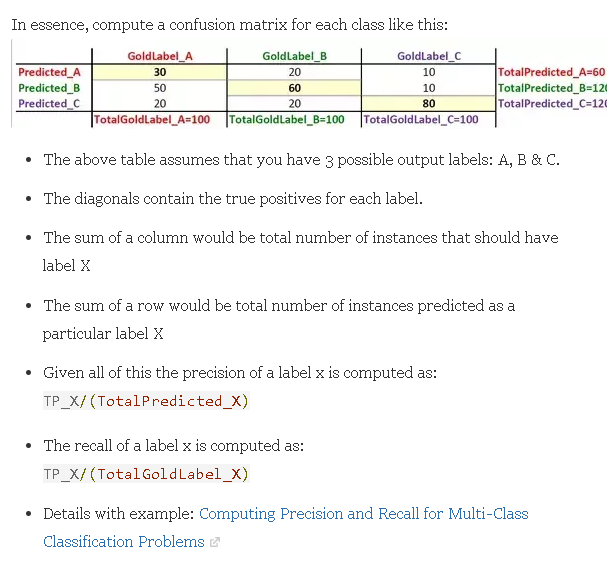

In the training dataset, the logistic regression model here classifies all the data into "US" or "NDF". 

In [164]:
Multinary_Logistic_Regression.classes_

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [157]:
from sklearn.cross_validation import cross_val_predict

In [158]:
y_train_pred=cross_val_predict(Multinary_Logistic_Regression, X_train, y_train, cv=5)

In [161]:
from sklearn.metrics import confusion_matrix

In [162]:
conf_mx=confusion_matrix(y_train, y_train_pred)

In [171]:
set(y_train_pred)

{'NDF', 'US'}

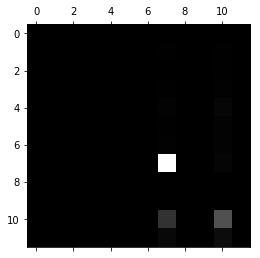

In [163]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Use the confusion matrix to plot on the errors:

Divide each value in the confusion matrix by the number of users in each predicted class.

In [179]:
row_sums=conf_mx.sum(axis=1, keepdims=True)

In [180]:
normed_conf_mx=conf_mx/row_sums

Fill the diagnol with zeros to keep only the errors and plot the results:

In [183]:
np.fill_diagonal(normed_conf_mx,0)

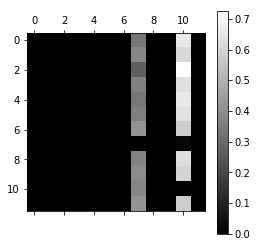

In [187]:
plt.matshow(normed_conf_mx, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

Validation the prediction on the test dataset:

In [188]:
print("Accuracy Score: ", cross_val_score(Multinary_Logistic_Regression, X_test,y_test, cv=5).mean())

Accuracy Score:  0.7388222870261943


# Leverage the function to evaluate the performance on the testing set:

The prediction model is doing very poorly for countries like AU, CA, PT, NT, DE, ES and GB. The prediction is very powerful to predict the user that has not done any booking and the users that have booked US as their first destination country in the testing dataset. This is because most of the users in the data have not booked their trips or have booked US as their first destination country.

In [192]:
logistic_regression_evaluation_final_df_test_set=funct_NDCG_score_output(Multinary_Logistic_Regression, X_test, y_test)
logistic_regression_evaluation_final_df_test_set.head()

,id,country,Probability,Rank,Score
0,kgdq6y9tit,NDF,0.969776,1.0,1.0
1,1mi71d5rbz,NDF,0.729796,1.0,1.0
2,kbrhe2kjpc,GB,NaN,NaN,0.0
3,mn6igynfia,NDF,0.632432,1.0,1.0
4,2dg0i1vggn,NDF,0.961464,1.0,1.0


The average score here for the model is 87%.

In [196]:
logistic_regression_evaluation_final_df_test_set.Score.mean()

0.8732669579923871

The average score by country looks similar to the result from the training set.

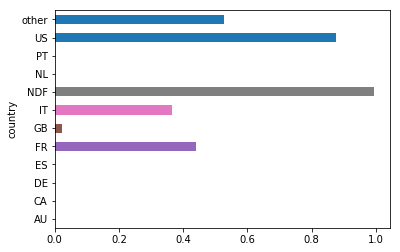

In [195]:
logistic_regression_evaluation_final_df_test_set.groupby('country')['Score'].mean().plot(kind='barh')

Below is the distribution of the score

In [214]:
logistic_regression_evaluation_final_df_test_set.Score.value_counts()

1.000000    32584
0.630930     5050
0.000000     1776
0.500000     1764
0.430677      949
0.386853      568
Name: Score, dtype: int64

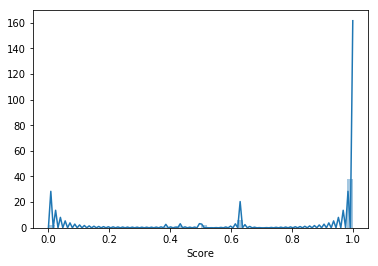

In [213]:
sns.distplot(logistic_regression_evaluation_final_df_test_set.Score)

In [197]:
y_test_pred=cross_val_predict(Multinary_Logistic_Regression, X_test, y_test, cv=5)

In [198]:
conf_mx_test=confusion_matrix(y_test, y_test_pred)

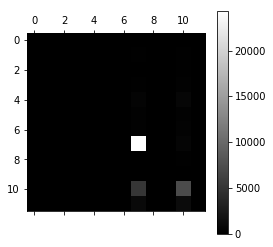

In [200]:
plt.matshow(conf_mx_test, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

Use the confusion matrix to plot on the errors:

In [207]:
row_sums_test=conf_mx_test.sum(axis=1, keepdims=True)

conf_mx_test_normalized=conf_mx_test/row_sums_test

In [209]:
np.fill_diagonal(conf_mx_test_normalized,0)

By looking at the error plot, we can see that since the model can only predict the "US" and "NDF" these two classes as the first destination country, the prediction is not accuracte and generates a lot of errors.

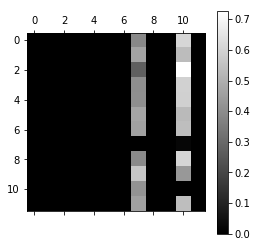

In [211]:
plt.matshow(conf_mx_test_normalized, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# Use Random Forest to train the model: 

In [506]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list2]

In [507]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [505]:
print("Shape of features of training dataset: ", X_train.shape)
print("Shape of features of testing dataset: ", X_test.shape)
print("Shape of labels of training dataset :", y_train.shape)
print("Shape of labels of testing dataset: ", y_test.shape)

Shape of features of training dataset:  (170760, 273)
Shape of features of testing dataset:  (42691, 273)
Shape of labels of training dataset : (170760,)
Shape of labels of testing dataset:  (42691,)


# Try Random Search with Cross Validation to get the best hyper parameter tuning:

In [224]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 500, num = 50)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [150,
                  157,
                  164,
                  171,
                  178,
                  185,
                  192,
                  200,
                  207,
                  214,
                  221,
                  228,
                  235,
                  242,
                  250,
                  257,
                  264,
                  271,
                  278,
                  285,
                  292,
                  300,
                  307,
                  314,
                  321,
                  328,
                  335,
                  342,
                  350,
                  357,
                  364,
                  371,
                  378,
                  385,
                  392,
                  400,
         

Use the Randomized Search CV to get the optimal hyperparameter:

In [241]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 50,
                              #scoring="roc_auc", 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 202.7min finished


Get the best parameters from the randomized search:

In [242]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 221}

Given the best hyperparameter recommeneded by the randomized search, narrow down the range for finalize the final hyperparameters to use for the model.

- Below are the hyperpatamers recommended by the randomized search:

bootstrap: True,

max_depth: 20,

min_samples_leaf: 4,

min_samples_split: 5,

n_estimators: 221

Create the parameter grid based on the results of the random search:

In [246]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [20, 22,24, 26, 28],
    'bootstrap':[True],
    'n_estimators': [221, 223, 225, 227],
    'min_samples_split': [10],
    'min_samples_leaf':[4]
}

# Create a base model
random_forest_clf = RandomForestClassifier(random_state = 22)

# Instantiate the grid search model
grid_search_random_forest = GridSearchCV(estimator = random_forest_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [248]:
# Fit the grid search to the data
grid_search_random_forest.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 40.8min finished


# Below are the best parameters out of the randomized search:

In [249]:
grid_search_random_forest.best_params_


{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 221}

In [251]:
best_grid_random_forest = grid_search_random_forest.best_estimator_


In [508]:
#best_grid_random_forest= RandomForestClassifier(bootstrap=True,max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=221 )


In [510]:
best_grid_random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=221, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Evaluate the performance of the random forest model

The average accuracy score for cross validation is 87%.

In [252]:
cross_val_score(best_grid_random_forest, X_test, y_test, cv=5)

array([0.87497073, 0.87517564, 0.87538065, 0.8754686 , 0.87557118])

In [259]:
set(best_grid_random_forest.predict(X_test))

{'NDF', 'US'}

random_forest_evaluation_final_df_test_set=funct_NDCG_score_output(best_grid_random_forest, X_test, y_test)
random_forest_evaluation_final_df_test_set.head()

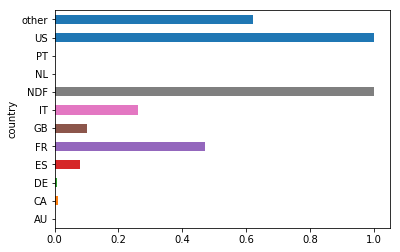

In [256]:
random_forest_evaluation_final_df_test_set.groupby('country')['Score'].mean().plot(kind='barh')

The average score for the finalized random forest classifier here is 92%.

In [260]:
random_forest_evaluation_final_df_test_set['Score'].mean()

0.9212873052098688

Below is the distribution of the score from the random forest model:

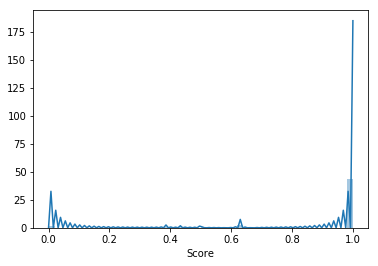

In [267]:
sns.distplot(random_forest_evaluation_final_df_test_set['Score'])

In [269]:
y_test_pred=cross_val_predict(best_grid_random_forest, X_test, y_test, cv=5)

Plot the confusion matrix:

By looking at the confusion matrix, you will find that since most of the data have "NDF" or "US" as label, the model can only ensure the accuracy in predicting these two labels.

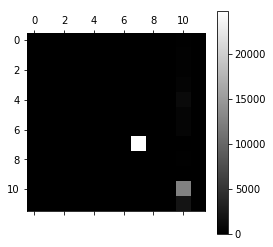

In [270]:
conf_mx_test=confusion_matrix(y_test, y_test_pred)
plt.matshow(conf_mx_test, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [278]:
y_test.value_counts()

NDF      24843
US       12525
other     2006
FR        1010
IT         562
GB         497
ES         451
CA         275
DE         208
NL         155
AU         114
PT          45
Name: country_destination, dtype: int64

In [281]:
row_sums_test=conf_mx_test.sum(axis=1, keepdims=True)

By looking at the error plot, a lot predictions toward "US" has generated many errors.


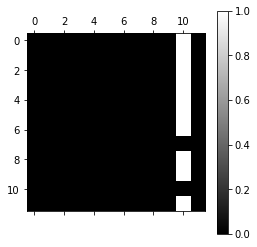

In [271]:
row_sums_test=conf_mx_test.sum(axis=1, keepdims=True)
conf_mx_test_normalized=conf_mx_test/row_sums_test
np.fill_diagonal(conf_mx_test_normalized,0)
plt.matshow(conf_mx_test_normalized, cmap=plt.cm.gray)
plt.colorbar()
plt.show()




<Figure size 720x432 with 0 Axes>

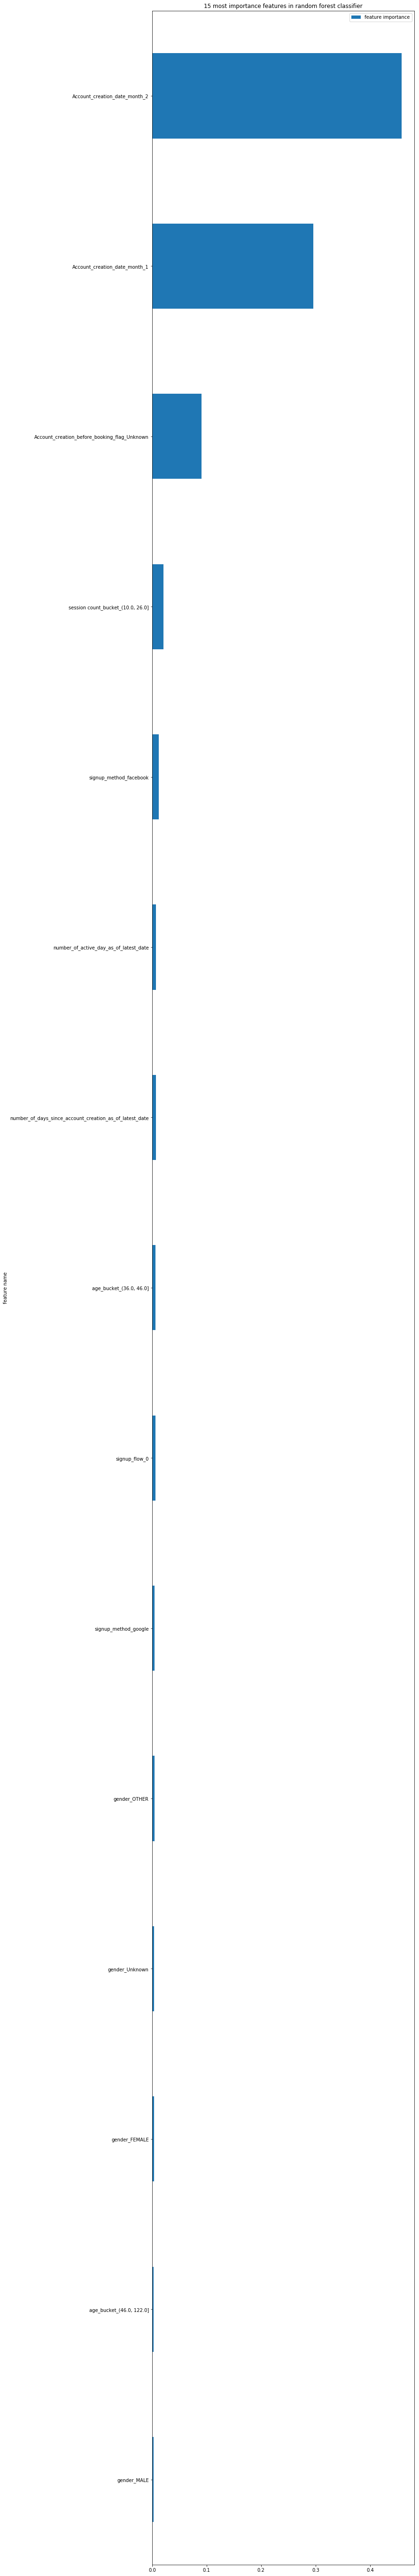

In [514]:
plt.figure(figsize=(10, 6))
model_random_forest_multi_class_feature_importance_df=pd.DataFrame(list(zip(feature_list1, best_grid_random_forest.feature_importances_)), columns=['feature name', 'feature importance'])
model_random_forest_multi_class_feature_importance_df=model_random_forest_multi_class_feature_importance_df.sort_values(by='feature importance', ascending=False)
model_random_forest_multi_class_feature_importance_df.set_index('feature name', inplace=True)
model_random_forest_multi_class_feature_importance_df[:15]. sort_values(by='feature importance', ascending=True).plot(kind='barh', title="15 most importance features in random forest classifier")
plt.show()

# Use XG boost to train the model

In [327]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [348]:
feature_list2.remove('country_destination')

In [350]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list2]

In [352]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=23)

In [353]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]


In [354]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [355]:
model_xgboost = XGBClassifier(max_depth=10,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=5,
                           silent=True,
                           objective='multi:softprob',
                           num_class=12,
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)

In [357]:
kfold = StratifiedKFold(n_splits=5, random_state=7)
results = cross_val_score(model_xgboost, X_train, y_train, cv=kfold, scoring='neg_log_loss')

The mean of the negative log loss is -1.32

In [365]:
results.mean()

-1.3171529408215963

In [366]:
model_xgboost.fit(X_train,  y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, num_class=12, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
       seed=1, silent=True, subsample=1)

In [367]:
y_predict=model_xgboost.predict(X_test)
y_pro = model_xgboost.predict_proba(X_test)[:, 1]

In [361]:
xgboost_evaluation_final_df_test_set=funct_NDCG_score_output(model_xgboost, X_test, y_test)
xgboost_evaluation_final_df_test_set.head()

,id,country,Probability,Rank,Score
0,5b4don41xd,NDF,0.355950,1.0,1.0
1,ybntp4vzug,US,0.268914,1.0,1.0
2,yv989run7q,NDF,0.355950,1.0,1.0
3,isdlmons7d,NDF,0.355950,1.0,1.0
4,suem0psnjk,NDF,0.355950,1.0,1.0


The average NDGC score is 0.93 and the accuracy score on the testing set is 0.87.

In [362]:
xgboost_evaluation_final_df_test_set.Score.mean()

0.9254644430741754

In [363]:
accuracy_score(y_test, model_xgboost.predict(X_test))

0.87468084607997

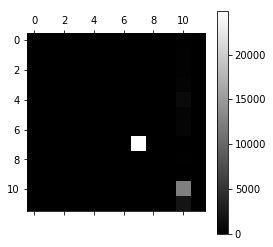

In [364]:
conf_xgb_test=confusion_matrix(y_test, model_xgboost.predict(X_test))
plt.matshow(conf_xgb_test, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# Below are the important features based on the xgboost model:

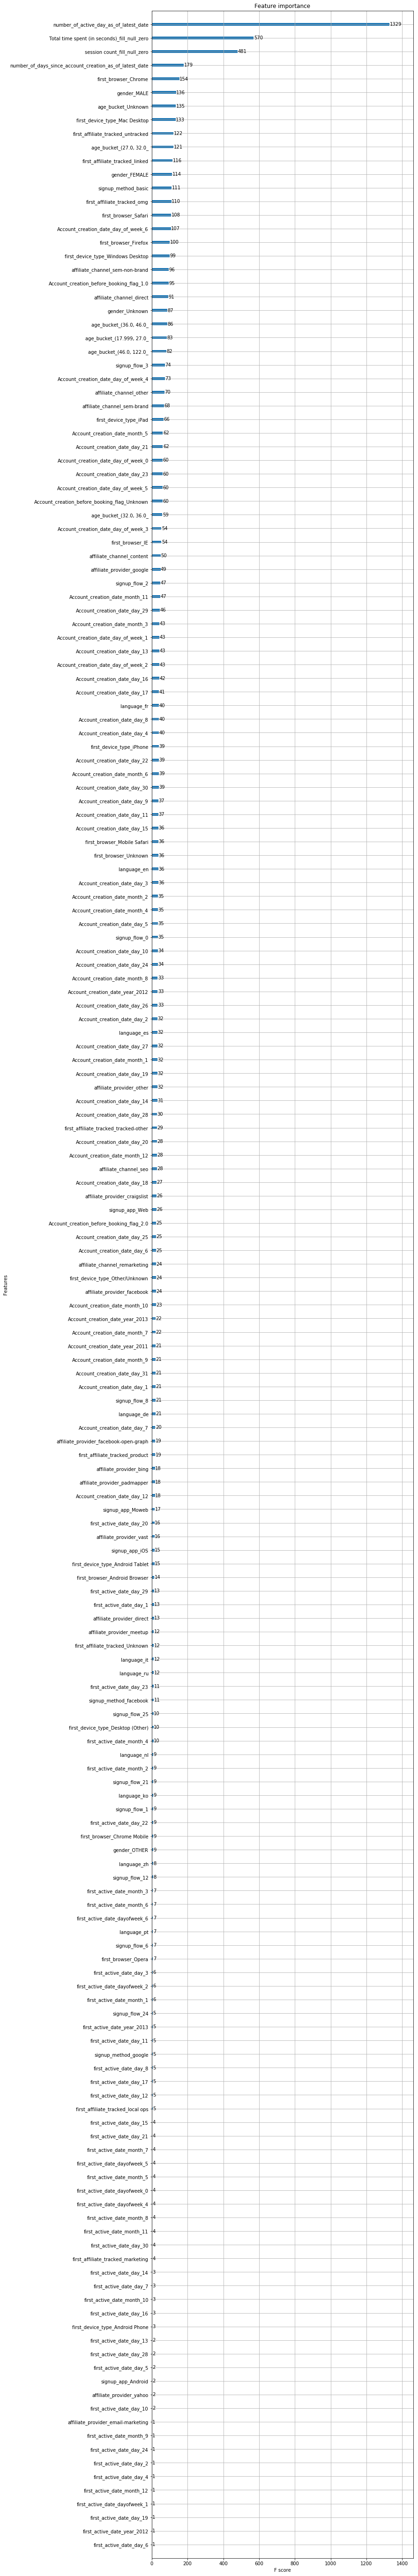

In [498]:
xgb.plot_importance(model_xgboost)
plt.rcParams['figure.figsize']=[10,100]
plt.show()

After trying out random forest, logistic regression and xgboost, I've decided to use xgboost since it's given me the best result. The next step for the project would be to leverage randomized search and grid search for hyperparameter tuning for the xgboost. Since tuning on the parameters and increasing the number of estimators would be quite expensive, I'm not going to try it for now.

# Leverage the xgboost model for predicting the testing dataset from kaggle:

In [247]:
sessions_raw=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/sessions.csv")
train_users_2_raw=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/train_users_2.csv")
test_users_raw=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/test_users.csv")
countries_raw=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/countries.csv")
age_gender_bkts_raw=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/age_gender_bkts.csv")

# Data Cleaning on the test user data set:

In [368]:

#Create a new dataframe to include the activity count by user:
user_activity_count=sessions_raw.groupby('user_id').size()
user_activity_count=user_activity_count.reset_index()
user_activity_count=user_activity_count.rename(columns={0: 'session count'})
user_activity_count.sort_values(by='session count', ascending=False, inplace=True)
user_activity_count.head()

#Create a new dataframe to include the total time spent on Airbnb by user:
user_total_time_spent=sessions_raw.groupby('user_id')['secs_elapsed'].sum()
user_total_time_spent=user_total_time_spent.reset_index()
user_total_time_spent=user_total_time_spent.rename(columns={'secs_elapsed': 'Total time spent (in seconds)'})
user_total_time_spent.sort_values(by='Total time spent (in seconds)', ascending=False, inplace=True)
user_total_time_spent.head()

user_total_time_spent['Total time spent (in seconds)']=pd.to_numeric(user_total_time_spent['Total time spent (in seconds)'])

#Clean up all the date and timestamp fields from the test_users_raw data frame:
test_users_raw['date_account_created']=pd.to_datetime(test_users_raw['date_account_created'])
test_users_raw['date_first_booking']=pd.to_datetime(test_users_raw['date_first_booking'])
test_users_raw['timestamp_first_active_cleaned']=pd.to_datetime(test_users_raw['timestamp_first_active'].apply(lambda x: str(x)[:8]).apply(lambda x: str(x)[:4]) +'-'+ test_users_raw['timestamp_first_active'].apply(lambda x: str(x)[:8]).apply(lambda x: str(x)[4:6]) + '-' + test_users_raw['timestamp_first_active'].apply(lambda x: str(x)[:8]).apply(lambda x: str(x)[6:]))

user_training_dataset_check_duplicate_df=test_users_raw.groupby('id').size().reset_index()
test_users_raw['number_of_days_account_creation']=test_users_raw['date_first_booking']-test_users_raw['date_account_created']

test_users_raw['number_of_active_days']=test_users_raw['date_first_booking']-test_users_raw['timestamp_first_active_cleaned']

#Create a field age_computed to compute the age lower than 18 to be 18 and the age over 122 to be 122 years old.
test_users_raw['age_computed']=test_users_raw['age']
test_users_raw.loc[test_users_raw['age_computed']>=122,'age_computed']=122
test_users_raw.loc[test_users_raw['age_computed']<18,'age_computed']=18

#Convert the timedelta to number of days (numeric value):
test_users_raw['number_of_days_account_creation_numeric_value']=test_users_raw['number_of_days_account_creation'].dt.days
test_users_raw['number_of_active_days_numeric_value']=test_users_raw['number_of_active_days'].dt.days

test_users_raw.loc[test_users_raw['number_of_days_account_creation_numeric_value']==0,'Account_creation_before_booking_flag']=1
test_users_raw.loc[test_users_raw['number_of_days_account_creation_numeric_value']>0,'Account_creation_before_booking_flag']=2
test_users_raw.loc[test_users_raw['number_of_days_account_creation_numeric_value']<0,'Account_creation_before_booking_flag']=0


user_final_testing_dataset=pd.merge(left=test_users_raw, right=user_activity_count, left_on="id", right_on="user_id", how='left')
user_final_testing_dataset=pd.merge(left=user_final_testing_dataset, right=user_total_time_spent, left_on="id", right_on="user_id", how='left')

# Feature engineering on the testing dataset:

In [485]:
#Create two more variables:
#number of active days as of December 2019
#number of days since account created as of December 2019

#Note that the lastest was picked based on the earliest activity/account creating in the training/testing dataset:

Latest_date=pd.to_datetime('2015-7-1')

user_final_testing_dataset['number_of_active_day_as_of_latest_date']=(Latest_date-user_final_testing_dataset['timestamp_first_active_cleaned']).dt.days
user_final_testing_dataset['number_of_days_since_account_creation_as_of_latest_date']=(Latest_date-user_final_testing_dataset['date_account_created']).dt.days

#Create a new dataframe user_final_testing_dataset_update to only include the variables that will be included in the model:
user_final_testing_dataset['date_account_created']=pd.to_datetime(user_final_testing_dataset['date_account_created'])
user_final_testing_dataset['timestamp_first_active_cleaned']=pd.to_datetime(user_final_testing_dataset['timestamp_first_active_cleaned'])

user_final_testing_dataset_update=user_final_testing_dataset[['id', 'date_account_created', 'timestamp_first_active_cleaned', 'gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked','signup_app', 'first_device_type', 'first_browser', 'age_computed',   'Account_creation_before_booking_flag', 'Total time spent (in seconds)', 'number_of_active_day_as_of_latest_date','number_of_days_since_account_creation_as_of_latest_date', 'session count']]

user_final_testing_dataset_update['first_browser']=user_final_testing_dataset_update['first_browser'].astype("str")
user_final_testing_dataset_update['gender']=user_final_testing_dataset_update['gender'].astype("str")

user_final_testing_dataset_update.loc[user_final_testing_dataset_update['first_browser']=='-unknown-', 'first_browser']='Unknown'
user_final_testing_dataset_update.loc[user_final_testing_dataset_update['gender']=='-unknown-', 'gender']='Unknown'

#Create variables including day of week, day of month, month and year for both account creation date and first active time stamp
user_final_testing_dataset_update['Account_creation_date_month'] = user_final_testing_dataset_update['date_account_created'].dt.month
user_final_testing_dataset_update['Account_creation_date_year'] = user_final_testing_dataset_update['date_account_created'].dt.year
user_final_testing_dataset_update['Account_creation_date_day']=user_final_testing_dataset_update['date_account_created'].dt.day
user_final_testing_dataset_update['Account_creation_date_day_of_week']=user_final_testing_dataset_update['date_account_created'].dt.dayofweek


user_final_testing_dataset_update['first_active_date_month']=user_final_testing_dataset_update['timestamp_first_active_cleaned'].dt.month
user_final_testing_dataset_update['first_active_date_day']=user_final_testing_dataset_update['timestamp_first_active_cleaned'].dt.day
user_final_testing_dataset_update['first_active_date_year']=user_final_testing_dataset_update['timestamp_first_active_cleaned'].dt.year
user_final_testing_dataset_update['first_active_date_dayofweek']=user_final_testing_dataset_update['timestamp_first_active_cleaned'].dt.dayofweek

#Fill the missing values for first_affiliate_tracked as "Unknown"

user_final_testing_dataset_update['first_affiliate_tracked']=user_final_testing_dataset_update['first_affiliate_tracked'].astype('str')
user_final_testing_dataset_update['first_affiliate_tracked'].fillna("Unknown", inplace=True)

#Create Age_bucket variable for age:
user_final_testing_dataset_update['age_bucket']=pd.qcut(user_final_testing_dataset_update['age_computed'], 5)
user_final_testing_dataset_update['age_bucket']=user_final_testing_dataset_update['age_bucket'].astype('str')
user_final_testing_dataset_update.loc[user_final_testing_dataset_update['age_bucket']=='nan','age_bucket']='Unknown'
user_final_testing_dataset_update['age_bucket']=pd.Categorical(user_final_testing_dataset_update['age_bucket'])

#For the total time spent in seconds and total session count variables, fill out the null values with 0.

user_final_testing_dataset_update['Total time spent (in seconds)_fill_null_zero']=user_final_testing_dataset_update['Total time spent (in seconds)'].fillna(0 )
user_final_testing_dataset_update['session count_fill_null_zero']=user_final_testing_dataset_update['session count'].fillna(0)
user_final_testing_dataset_update['Total time spent (in seconds)_bucket']=pd.qcut(user_final_testing_dataset_update['Total time spent (in seconds)'], 5, duplicates='drop')

user_final_testing_dataset_update['Total time spent (in seconds)_bucket']=user_final_testing_dataset_update['Total time spent (in seconds)_bucket'].astype('str')
user_final_testing_dataset_update.loc[user_final_testing_dataset_update['Total time spent (in seconds)_bucket']=='nan','Total time spent (in seconds)_bucket']='Unknown'
user_final_testing_dataset_update['Total time spent (in seconds)_bucket']=pd.Categorical(user_final_testing_dataset_update['Total time spent (in seconds)_bucket'])

user_final_testing_dataset_update['session count_bucket']=pd.qcut(user_final_testing_dataset_update['session count'], 5, duplicates='drop')

user_final_testing_dataset_update['session count_bucket']=user_final_testing_dataset_update['session count_bucket'].astype('str')
user_final_testing_dataset_update.loc[user_final_testing_dataset_update['session count_bucket']=='nan','session count_bucket']='Unknown'
user_final_testing_dataset_update['session count_bucket']=pd.Categorical(user_final_testing_dataset_update['session count_bucket'])

user_testing_dataset_update_multinary_classfication=user_final_testing_dataset_update.copy()
user_testing_dataset_update_multinary_classfication.loc[user_testing_dataset_update_multinary_classfication['first_browser']=='-unknown-', 'first_browser']='Unknown'
user_testing_dataset_update_multinary_classfication.loc[user_testing_dataset_update_multinary_classfication['gender']=='-unknown-', 'gender']='Unknown'

user_testing_dataset_update_multinary_classfication.loc[pd.isnull(user_testing_dataset_update_multinary_classfication['first_affiliate_tracked']), 'first_affiliate_tracked']='Unknown'
user_testing_dataset_update_multinary_classfication.loc[pd.isnull(user_testing_dataset_update_multinary_classfication['Account_creation_before_booking_flag']), 'Account_creation_before_booking_flag']='Unknown'

user_testing_dataset_update_multinary_classfication['age_bucket']=user_testing_dataset_update_multinary_classfication['age_bucket'].astype(str)

user_testing_dataset_update_multinary_classfication.loc[(user_testing_dataset_update_multinary_classfication['age_computed']>36) & (user_testing_dataset_update_multinary_classfication['age_computed']<=46),'age_bucket']='(36.0, 46.0]'
user_testing_dataset_update_multinary_classfication.loc[(user_testing_dataset_update_multinary_classfication['age_computed']>46) & (user_testing_dataset_update_multinary_classfication['age_computed']<=122),'age_bucket']='(46.0, 122.0]'
user_testing_dataset_update_multinary_classfication.loc[(user_testing_dataset_update_multinary_classfication['age_computed']>32) & (user_testing_dataset_update_multinary_classfication['age_computed']<=36),'age_bucket']='(32.0, 36.0]'
user_testing_dataset_update_multinary_classfication.loc[(user_testing_dataset_update_multinary_classfication['age_computed']>27) & (user_testing_dataset_update_multinary_classfication['age_computed']<=32),'age_bucket']='(27.0, 32.0]'
user_testing_dataset_update_multinary_classfication.loc[(user_testing_dataset_update_multinary_classfication['age_computed']>17.999) & (user_testing_dataset_update_multinary_classfication['age_computed']<=27),'age_bucket']='(17.999, 27.0]'
user_testing_dataset_update_multinary_classfication.loc[pd.isnull(user_testing_dataset_update_multinary_classfication['age_computed']),'age_bucket']='Unknown'

user_testing_dataset_update_multinary_classfication['age_bucket']=user_testing_dataset_update_multinary_classfication['age_bucket'].astype("category")


def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df


Categorical_variable_list=['gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket']


user_testing_dataset_update_multinary_classfication1=user_testing_dataset_update_multinary_classfication.copy()

user_testing_dataset_update_multinary_classfication1=user_testing_dataset_update_multinary_classfication1[[
'id',
    
# Below are the category variables:
'gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket',                                          

#Below are the continuous variables:

'number_of_active_day_as_of_latest_date', 
'number_of_days_since_account_creation_as_of_latest_date',
'Total time spent (in seconds)_fill_null_zero',   
'session count_fill_null_zero' ]]  



for variable_name in Categorical_variable_list:
    df_dummy_test_set=func_get_dummy_variables_for_categorical_variables(user_testing_dataset_update_multinary_classfication1, variable_name)
    user_testing_dataset_update_multinary_classfication1=user_testing_dataset_update_multinary_classfication1.merge(df_dummy_test_set, on=None, left_index=True, right_index=True)


user_testing_dataset_update_multinary_classfication1=user_testing_dataset_update_multinary_classfication1.set_index('id')

user_testing_dataset_update_multinary_classfication1.info()         

feature_list2=list(user_training_dataset_update_multinary_classfication1.columns)

feature_list2.remove('Total time spent (in seconds)_bucket_(-0.001, 169857.6]')
feature_list2.remove('Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]')
feature_list2.remove('Total time spent (in seconds)_bucket_(169857.6, 584557.4]')
feature_list2.remove('Total time spent (in seconds)_bucket_(2444996.4, 38221363.0]')
feature_list2.remove('Total time spent (in seconds)_bucket_(584557.4, 1248857.2]')
feature_list2.remove('Total time spent (in seconds)_bucket_Unknown')

feature_list2.remove('session count_bucket_(0.999, 10.0]')
feature_list2.remove('session count_bucket_(10.0, 26.0]')
feature_list2.remove('session count_bucket_(111.0, 2644.0]')
feature_list2.remove('session count_bucket_(26.0, 53.0]')
feature_list2.remove('session count_bucket_(53.0, 111.0]')
feature_list2.remove('session count_bucket_Unknown')
feature_list2.remove('country_destination')

features_to_drop_list=[i for i in user_testing_dataset_update_multinary_classfication1.columns if i not in feature_list2]
features_to_add_list=[i for i in feature_list2 if i not in user_testing_dataset_update_multinary_classfication1.columns]
df_to_add=pd.DataFrame(index=user_testing_dataset_update_multinary_classfication1.index, columns=features_to_add_list)
df_to_add.fillna(0, inplace=True)
user_testing_dataset_update_multinary_classfication1=pd.merge(user_testing_dataset_update_multinary_classfication1, df_to_add, left_index=True, right_index=True)
user_testing_dataset_update_multinary_classfication1=user_testing_dataset_update_multinary_classfication1.drop(features_to_drop_list, axis=1)

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
user_testing_dataset_update_multinary_classfication1.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in user_testing_dataset_update_multinary_classfication1.columns.values]

user_testing_dataset_update_multinary_classfication1=user_testing_dataset_update_multinary_classfication1[X_train.columns]


C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

<class 'pandas.core.frame.DataFrame'>
Index: 62096 entries, 5uwns89zht to 9uqfg8txu3
Columns: 222 entries, number_of_active_day_as_of_latest_date to Total time spent (in seconds)_bucket_Unknown
dtypes: float64(2), int64(2), uint8(218)
memory usage: 15.3+ MB


# Use XGBoost to predict on the testing set:

In [486]:
y_testing_prediction=model_xgboost.predict(user_testing_dataset_update_multinary_classfication1)

In [487]:
y_testing_prediction_probability=model_xgboost.predict_proba(user_testing_dataset_update_multinary_classfication1)

In [459]:
training_set_preiction_class=multinary_classification_model_predict_class(model_xgboost, X_train)

In [488]:
testing_set_prediction_class=multinary_classification_model_predict_class(model_xgboost, user_testing_dataset_update_multinary_classfication1)

In [462]:
training_set_prediction_top_5_countries=multinary_classification_model_predict_probability_by_class(model_xgboost, X_train)

In [489]:
testing_set_prediction_top_5_countries=multinary_classification_model_predict_probability_by_class(model_xgboost, user_testing_dataset_update_multinary_classfication1)

In [497]:
testing_set_prediction_class.to_csv("C:/Users/yuka.abe/Desktop/Airbnb_kaggle_competition_prediction_output.csv")


In [495]:
testing_set_prediction_top_5_countries

,id,variable,Probability
459917,0010k6l0om,NDF,0.35595
25245,0010k6l0om,AU,0.05855
87341,0010k6l0om,CA,0.05855
149437,0010k6l0om,DE,0.05855
211533,0010k6l0om,ES,0.05855
490166,0031awlkjq,NDF,0.35595
55494,0031awlkjq,AU,0.05855
117590,0031awlkjq,CA,0.05855
179686,0031awlkjq,DE,0.05855
241782,0031awlkjq,ES,0.05855


In [468]:
training_set_prediction_top_5_countries

,id,variable,Probability
1740821,00023iyk9l,US,0.281435
1911581,00023iyk9l,other,0.084377
716261,00023iyk9l,FR,0.067936
1057781,00023iyk9l,IT,0.066069
887021,00023iyk9l,GB,0.065348
1260017,0005ytdols,NDF,0.355950
64697,0005ytdols,AU,0.058550
235457,0005ytdols,CA,0.058550
406217,0005ytdols,DE,0.058550
576977,0005ytdols,ES,0.058550


In [474]:
X_train['number_of_days_since_account_creation_as_of_latest_date'].describe()

count    170760.000000
mean        735.512550
std         312.372553
min         366.000000
25%         482.000000
50%         658.000000
75%         917.000000
max        2006.000000
Name: number_of_days_since_account_creation_as_of_latest_date, dtype: float64

In [473]:
user_testing_dataset_update_multinary_classfication1['number_of_days_since_account_creation_as_of_latest_date'].describe()

count    62096.000000
mean      1962.191301
std         25.698322
min       1916.000000
25%       1941.000000
50%       1963.000000
75%       1984.000000
max       2007.000000
Name: number_of_days_since_account_creation_as_of_latest_date, dtype: float64

In [464]:
training_set_prediction_top_5_countries

,id,variable,Probability
1740821,00023iyk9l,US,0.281435
1911581,00023iyk9l,other,0.084377
716261,00023iyk9l,FR,0.067936
1057781,00023iyk9l,IT,0.066069
887021,00023iyk9l,GB,0.065348
1260017,0005ytdols,NDF,0.355950
64697,0005ytdols,AU,0.058550
235457,0005ytdols,CA,0.058550
406217,0005ytdols,DE,0.058550
576977,0005ytdols,ES,0.058550
